In [1]:
cd /rdma/vast-rdma/vast/fiete/leokoz8/code/add_RL

/rdma/vast-rdma/vast/fiete/leokoz8/code/add_RL


In [77]:
import numpy as np
import matplotlib.pyplot as plt
from src import utils
from tqdm import tqdm
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
def update_Q_function(Q,s,s_prime,a,r,gamma,alpha):

    delta = r + gamma*np.max(Q[s_prime,:]) - Q[s,a]
    Q[s,a] += alpha*delta
    
    return Q

def update_Q_and_E(Q,E,s,s_prime,a,a_prime,r,gamma,alpha,lam):
    delta = r + gamma*np.max(Q[s_prime,:]) - Q[s,a]
    #delta = r + gamma*Q[s_prime,a_prime] - Q[s,a]
    E[s,a] += 1
    
    Q += alpha*delta*E
    E = E*gamma*lam 
    
    return Q,E

In [94]:
import gymnasium as gym
env = gym.make("FrozenLake-v1",render_mode = "rgb_array",map_name="4x4")
action_size = env.action_space.n
state_size = env.observation_space.n

T = int(100)
total_episodes = 60000
#to animate
frames = []


#epsilon greedy
max_epsilon = 1
min_epsilon = 0.01
decay_rate = 1e-3

gamma = 0.95
learning_rate = 0.1
lam = 0.9


#initialize Q function
Q = np.zeros((state_size,action_size))
E = np.zeros((state_size,action_size))

# List of rewards
rewards = []

# 2 For life or until learning is stopped
for episode in tqdm(range(total_episodes)):
    
    # Reset the environment
    s, info = env.reset(seed=42)
    step = 0
    total_rewards = 0
    #a = np.argmax(Q[s,:])
    a_prime = 0 
    
    # Reduce epsilon (because we need less and less exploration)    
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode) 


    for t in range(T):

        if np.random.uniform(0,1) > epsilon:
            a = np.argmax(Q[s,:])            
        else:
            a = env.action_space.sample()
            

        s_prime, r, terminated, truncated, info = env.step(a)

        #Q[s, a] = Q[s, a] + learning_rate * (r + gamma * np.max(Q[s_prime, :]) - Q[s, a])
        #Q = update_Q_function(Q,s,s_prime,a,r,gamma,learning_rate)
        Q,E = update_Q_and_E(Q,E,s,s_prime,a,a_prime,r,gamma,learning_rate,lam)
        
        assert np.linalg.norm(Q) <= 1e3, print('Q explosion!')

        s = s_prime
        #a = a_prime

        total_rewards += r


        #uncomment to store frames for animation
        #frames.append(env.render())


        if terminated or truncated:
            break          
        
    
    rewards.append(total_rewards)
env.close()

print ("Score over time: " +  str(sum(rewards)/total_episodes))

100%|██████████| 60000/60000 [00:30<00:00, 1947.80it/s]

Score over time: 0.9163


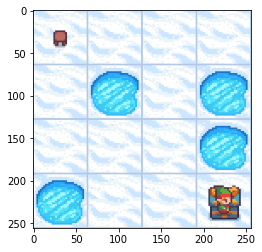

In [95]:
plt.imshow(env.render())

In [97]:
np.max(E)

1.3943821939533123

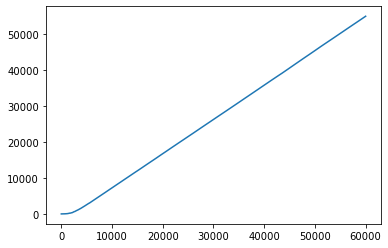

In [96]:
plt.plot(np.cumsum(rewards))

Remaining number of frames : 70
Remaining number of frames : 70
Remaining number of frames : 69
Remaining number of frames : 68
Remaining number of frames : 67
Remaining number of frames : 66
Remaining number of frames : 65
Remaining number of frames : 64
Remaining number of frames : 63
Remaining number of frames : 62
Remaining number of frames : 61
Remaining number of frames : 60
Remaining number of frames : 59
Remaining number of frames : 58
Remaining number of frames : 57
Remaining number of frames : 56
Remaining number of frames : 55
Remaining number of frames : 54
Remaining number of frames : 53
Remaining number of frames : 52
Remaining number of frames : 51
Remaining number of frames : 50
Remaining number of frames : 49
Remaining number of frames : 48
Remaining number of frames : 47
Remaining number of frames : 46
Remaining number of frames : 45
Remaining number of frames : 44
Remaining number of frames : 43
Remaining number of frames : 42
Remaining number of frames : 41
Remainin

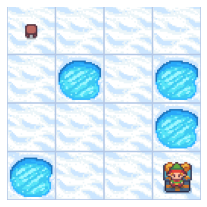

In [140]:
env.reset()
frames = []

for episode in range(10):
    
    s,info = env.reset(seed=42)

    for step in range(T):
        
        # Take the action (index) that have the maximum expected future reward given that state
        a = np.argmax(Q[s,:])
        
        s_prime, r, terminated, truncated, info = env.step(a)
        frames.append(env.render())
        if terminated or truncated:
            break
        s = s_prime
env.close()

utils.save_frames_as_gif(frames)

In [ ]:
    def sarsa_lambda(env, num_episodes, discount=0.9, alpha=0.01, trace_decay=0.9, epsilon=0.1, type='accumulate'):
    
        Q = defaultdict(lambda: np.zeros(env.nA))
        E = defaultdict(lambda: np.zeros(env.nA))
    
    
        for i_episode in range(num_episodes):
    
            print("\rEpisode {}/{}. ({})".format(i_episode+1, num_episodes, rewards[-1]), end="")
            sys.stdout.flush()
    
            state = env.reset()
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
    
            for t in itertools.count():
    
                next_state, reward, done, _ = env.step(action)
    
                next_action_probs = policy(next_state)
                next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)
    
                delta = reward + discount*Q[next_state][next_action] - Q[state][action]
    
                stats.episode_rewards[i_episode] += reward
    
                E[state][action] += 1
    
                for s, _ in Q.items():
                    Q[s][:] += alpha * delta * E[s][:]
                    if type == 'accumulate':
                        E[s][:] *= trace_decay * discount
                    elif type == 'replace':
                        if s == state:
                            E[s][:] = 1
                        else:
                            E[s][:] *= discount * trace_decay
    
                if done:
                    break
    
                state = next_state
                action = next_action
    
        return Q, stats
    